In [3]:

from pyspark.sql import SparkSession
#spark = SparkSession.builder.master("yarn").appName("Project").getOrCreate()

spark = SparkSession.builder \
    .master("yarn") \
    .appName("project")\
    .getOrCreate()

In [4]:
import pyspark as py
get_ipython().run_line_magic('matplotlib', 'inline')
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'retina'")
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import sys


In [5]:
print(spark)

In [6]:
spark.sparkContext.addFile("https://opendata.ecdc.europa.eu/covid19/casedistribution/csv")


covid=spark.read.csv(py.SparkFiles.get("csv"), header=True)

population_density=spark.read.format('csv').options(header='true', inferSchema='true', delimiter=';').load("/mnt/project-cluster-group18-pvc/population_density.csv")
hospital_beds=spark.read.format('csv').options(header='true', inferSchema='true', delimiter=',').load("/mnt/project-cluster-group18-pvc/Hospital_beds.csv")
median_age=spark.read.format('csv').options(header='true', inferSchema='true', delimiter=',').load("/mnt/project-cluster-group18-pvc/MedianAge.csv")
gdp=spark.read.format('csv').options(header='true', inferSchema='true', delimiter=';').load("/mnt/project-cluster-group18-pvc/GDP.csv")

In [7]:
#covid.show(vertical=True)

#hospital_beds.show(vertical=True)
#population_density.show(vertical=True)
#median_age.show()
#gdp.select().show()

In [8]:
from datetime import datetime
from pyspark.sql.functions import col, udf
from pyspark.sql.types import *

covid.dtypes

func =  udf(lambda x: datetime.strptime(x, '%d/%m/%Y'), DateType())
covid = covid.withColumn('dateRep', func(col('dateRep')))

covid = covid.withColumn("popData2018",covid["popData2018"].cast(IntegerType()))
covid = covid.withColumn("cases",covid["cases"].cast(IntegerType()))
covid = covid.withColumn("deaths",covid["deaths"].cast(IntegerType()))
#covid.dtypes
#covid.show()
covid.printSchema()


[('dateRep', 'string'),
 ('day', 'string'),
 ('month', 'string'),
 ('year', 'string'),
 ('cases', 'string'),
 ('deaths', 'string'),
 ('countriesAndTerritories', 'string'),
 ('geoId', 'string'),
 ('countryterritoryCode', 'string'),
 ('popData2018', 'string'),
 ('continentExp', 'string')]

root
 |-- dateRep: date (nullable = true)
 |-- day: string (nullable = true)
 |-- month: string (nullable = true)
 |-- year: string (nullable = true)
 |-- cases: integer (nullable = true)
 |-- deaths: integer (nullable = true)
 |-- countriesAndTerritories: string (nullable = true)
 |-- geoId: string (nullable = true)
 |-- countryterritoryCode: string (nullable = true)
 |-- popData2018: integer (nullable = true)
 |-- continentExp: string (nullable = true)



In [9]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

covid=covid.withColumn("cases2", (F.col("cases")/F.col("popData2018"))*100000)# cases per 100 000 people
covid=covid.withColumn("deaths2", (F.col("deaths")/F.col("popData2018"))*100000)# deaths per 100 000 people

win_spec = Window.partitionBy('countryterritoryCode').orderBy('dateRep').rowsBetween(-sys.maxsize, 0)
covid=covid.withColumn("casesCumsum", F.sum(covid.cases).over(win_spec))#cumsum of cases
covid=covid.withColumn("deathsCumsum", F.sum(covid.deaths).over(win_spec))#cumsum of deaths

covid=covid.withColumn("casesCumsum2", F.sum(covid.cases2).over(win_spec))#cumsum of cases per 100 000 people
covid=covid.withColumn("deathsCumsum2", F.sum(covid.deaths2).over(win_spec))#cumsum of death per 100 000 people

covid=covid.withColumn("deathRate", (F.col("deathsCumsum")/F.col("casesCumsum")))#death rate


covid = covid.withColumnRenamed("countriesAndTerritories", "Country")
covid = covid.withColumnRenamed("countryterritoryCode", "CountryId")

#rolling slope
#This don't work
#covid.withColumn("slope", 
#windows = covid.groupby('dateRep')["casesCumsum"].rolling(1)
#windows.apply(lambda x: np.polyfit(range(1), x, 1)[0], raw=True).values

covid = covid.select("dateRep","Country","CountryId","geoId","cases","deaths","casesCumsum","deathsCumsum","cases2", "deaths2","casesCumsum2","deathsCumsum2", "deathRate","popData2018")
covid.printSchema()

root
 |-- dateRep: date (nullable = true)
 |-- Country: string (nullable = true)
 |-- CountryId: string (nullable = true)
 |-- geoId: string (nullable = true)
 |-- cases: integer (nullable = true)
 |-- deaths: integer (nullable = true)
 |-- casesCumsum: long (nullable = true)
 |-- deathsCumsum: long (nullable = true)
 |-- cases2: double (nullable = true)
 |-- deaths2: double (nullable = true)
 |-- casesCumsum2: double (nullable = true)
 |-- deathsCumsum2: double (nullable = true)
 |-- deathRate: double (nullable = true)
 |-- popData2018: integer (nullable = true)



In [10]:
#population_density.printSchema()
population_density = population_density.withColumnRenamed("Country Name","Country")
population_density = population_density.withColumnRenamed("2018","density18")
population_density = population_density.withColumnRenamed("2017","density17")


latestAvailablePD = population_density.filter(F.col('density18').isNotNull()).selectExpr("Country","density18 as populationDensity").union(population_density.filter(F.col('density18').isNull()).selectExpr("Country","density17 as populationDensity"))

population_density = latestAvailablePD


#population_density = population_density.select("Country","density17", "density18")
population_density.printSchema()

root
 |-- Country: string (nullable = true)
 |-- populationDensity: double (nullable = true)



In [11]:
hospital_beds = hospital_beds.withColumnRenamed("LOCATION", "CountryId")

from pyspark.sql.functions import (col, max as max_, struct, monotonically_increasing_id)
from pyspark.ml.feature import VectorAssembler


#assembler = VectorAssembler(inputCols=hospital_beds.select(F.col("CountryId")).distinct().columns,outputCol='features')
#country_array = assembler.transform(hospital_beds.select(F.col("CountryId")).distinct())
#country_array

schema = StructType([StructField("CountryId", StringType(), True),StructField("Year", StringType(), True), StructField("latestAvailable", DoubleType(), False)])
latestAvailableHB = spark.createDataFrame([],schema)
for countryid in hospital_beds.select(F.col("CountryId")).distinct().collect():
    df = hospital_beds.filter(F.col('CountryId') == countryid[0])
    with_id = df.withColumn("_id", monotonically_increasing_id())
    i = with_id.select(max_("_id")).first()[0]
    newrow=with_id.where(col("_id") == i).selectExpr("CountryId","TIME as Year","Value as latestAvailable")
    latestAvailableHB = latestAvailableHB.union(newrow)

hospital_beds = latestAvailableHB

#hospital_beds = hospital_beds.select('CountryId', 'TIME', 'Value')
#hospital_beds.show()
hospital_beds.printSchema()

root
 |-- CountryId: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- latestAvailable: double (nullable = true)



In [12]:

median_age = median_age.withColumnRenamed("_c0", "Country")
median_age = median_age.withColumnRenamed("Population median age (years)","medianAge")
median_age = median_age.select("Country", "medianAge")
median_age.printSchema()


root
 |-- Country: string (nullable = true)
 |-- medianAge: double (nullable = true)



In [13]:
gdp = gdp.withColumnRenamed("Country Name","Country")
gdp = gdp.withColumnRenamed("2018","gdp18")
gdp = gdp.withColumnRenamed("2017","gdp17")
gdp = gdp.select("Country", "gdp17", "gdp18")

latestAvailableGDP = gdp.filter(F.col('gdp18').isNotNull()).selectExpr("Country","gdp18 as GDP").union(gdp.filter(F.col('gdp18').isNull()).selectExpr("Country","gdp17 as GDP"))

gdp = latestAvailableGDP
gdp.printSchema()


root
 |-- Country: string (nullable = true)
 |-- GDP: double (nullable = true)



In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date


#date.today().strftime("%Y-%m-%d")


NordicCountries=covid.filter((F.col('dateRep') == "2020-05-05") & ((F.col('Country') == 'Finland') | (F.col('Country') =='Sweden') | (F.col('Country') =='Norway')| (F.col('Country') =='Denmark'))).selectExpr('Country','CountryId','geoId','dateRep as Date',"round(casesCumsum,0) as TotalCases","round(deathsCumsum,0) as TotalDeaths","round(casesCumsum2,2) as TotalCasesper100000","round(deathsCumsum2,2) as TotalDeathsper100000 ","round(deathRate,3) as DeathRate", "popData2018 as Population2018")

NordicCountries.show()

#NC2 = hospital_beds.filter(((F.col('TIME')=='2017') & ((F.col('CountryId') == 'FIN') | (F.col('CountryId') =='SWE') | (F.col('CountryId') =='NOR')))| ((F.col('TIME')=='2018') & (F.col('CountryId') =='DNK'))).selectExpr('CountryId', 'TIME as HospitalBedsYear','round(Value,2) as HospitalBeds')

NC2 = hospital_beds.filter((F.col('CountryId') == 'FIN') | (F.col('CountryId') =='SWE') | (F.col('CountryId') =='NOR')|  (F.col('CountryId') =='DNK')).selectExpr('CountryId', 'Year as HospitalBedsYear','round(latestAvailable,2) as HospitalBeds')

NC2.show()

NC3 = population_density.filter((F.col('Country') == 'Finland') | (F.col('Country') =='Sweden') | (F.col('Country') =='Norway')| (F.col('Country') =='Denmark')).selectExpr('Country', 'round(populationDensity,1) as PopulationDensity2018')

NC3.show()

NC4 =  median_age.filter((F.col('Country') == 'Finland') | (F.col('Country') =='Sweden') | (F.col('Country') =='Norway')| (F.col('Country') =='Denmark'))

NC4.show()

NC5 = gdp.filter((F.col('Country') == 'Finland') | (F.col('Country') =='Sweden') | (F.col('Country') =='Norway')| (F.col('Country') =='Denmark')).selectExpr('Country', 'GDP')

NC5.show()

NordicCountries = NordicCountries.join(NC3, on=['Country'], how='inner')
NordicCountries = NordicCountries.join(NC2, on=['CountryId'], how='inner')
NordicCountries = NordicCountries.join(NC4, on=['Country'], how='inner')
NordicCountries.join(NC5, on=['Country'], how='inner').show(vertical=True)

+-------+---------+-----+----------+----------+-----------+-------------------+--------------------+---------+--------------+
|Country|CountryId|geoId|      Date|TotalCases|TotalDeaths|TotalCasesper100000|TotalDeathsper100000|DeathRate|Population2018|
+-------+---------+-----+----------+----------+-----------+-------------------+--------------------+---------+--------------+
| Norway|      NOR|   NO|2020-05-05|      7847|        208|             147.66|                3.91|    0.027|       5314336|
|Finland|      FIN|   FI|2020-05-05|      5327|        240|              96.54|                4.35|    0.045|       5518050|
|Denmark|      DNK|   DK|2020-05-05|      9670|        493|              166.8|                 8.5|    0.051|       5797446|
| Sweden|      SWE|   SE|2020-05-05|     22721|       2769|             223.12|               27.19|    0.122|      10183175|
+-------+---------+-----+----------+----------+-----------+-------------------+--------------------+---------+--------

In [15]:
covid_pd= covid.toPandas()
#covid_pd['dateRep'] = pd.to_datetime(covid_pd.dateRep, format='%d/%m/%Y')
#covid_pd['cases'] = pd.to_numeric(covid_pd.cases)


Text(0.5, 0, 'date')

Text(0, 0.5, 'cases per 100 000 people')

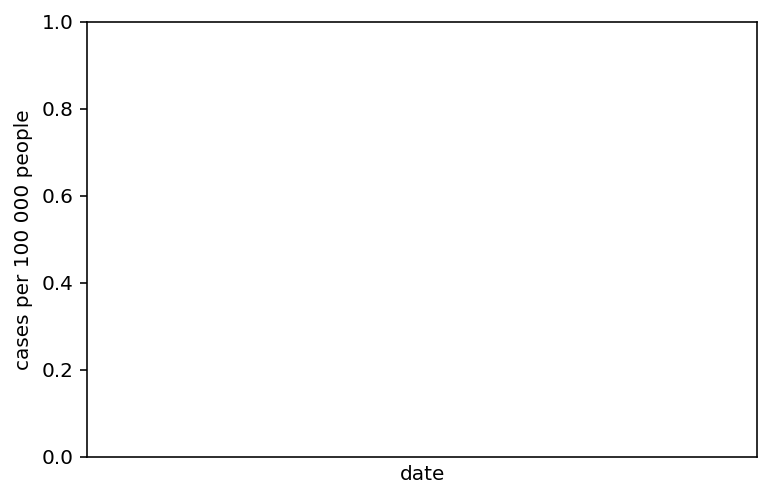

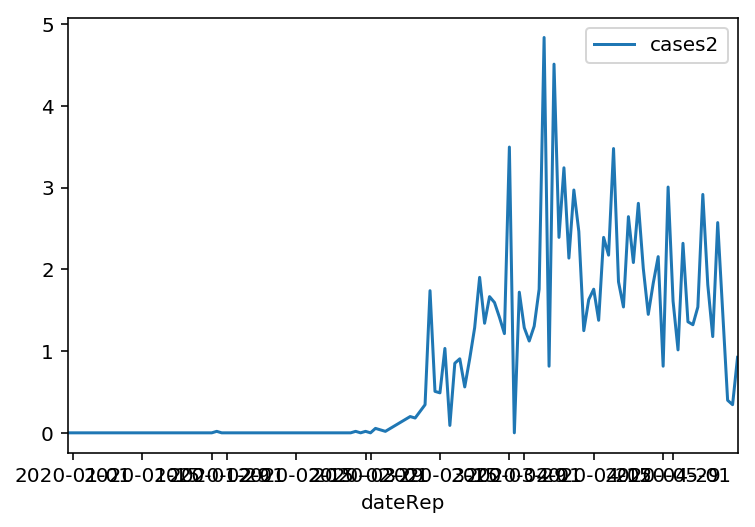

In [16]:
import matplotlib.dates as mdates
fig,ax = plt.subplots()
#ax.plot(covid_pd[covid_pd.countriesAndTerritories == "Finland"].dateRep,covid_pd[covid_pd.countriesAndTerritories == country].cases2, label="Finland")

covid_pd[covid_pd.Country == "Finland"].plot('dateRep','cases2')

ax.set_xlabel("date")
ax.set_ylabel("cases per 100 000 people")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Cases (SMA) per 100 000 people')

Text(0.5, 1.0, 'Cases curve of COVID-19 in the Nordic countries in 2020')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Deaths (SMA) per 100 000 people')

Text(0.5, 1.0, 'Deaths curve of COVID-19 in the Nordic countries in 2020')

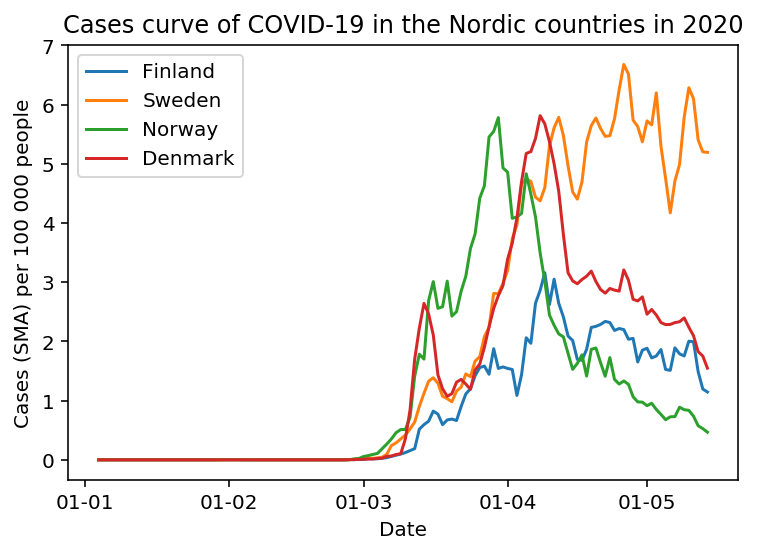

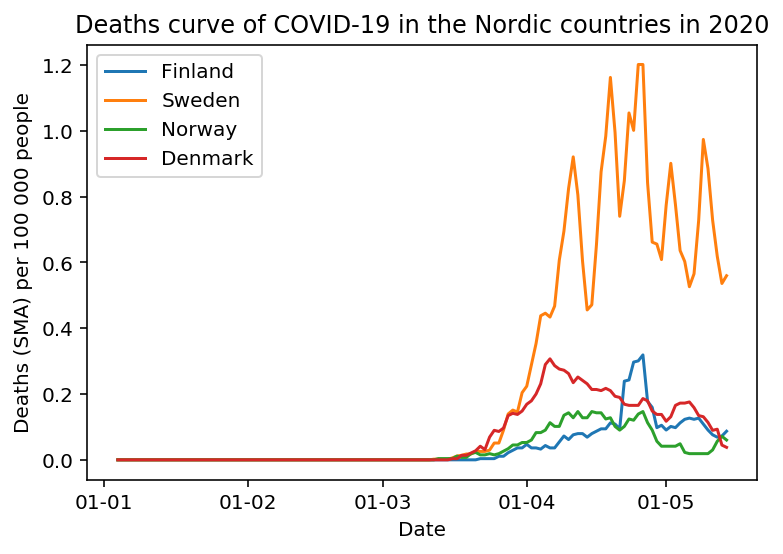

In [17]:

#covid_pd[covid_pd.countriesAndTerritories == "Finland"]

covid_pd['cases_SMA']=covid_pd.groupby('Country')['cases2'].transform(lambda x: x.rolling(window=5).mean())#Simple Moving Average (SMA) of cases


covid_pd['deaths_SMA']=covid_pd.groupby('Country')['deaths2'].transform(lambda x: x.rolling(window=5).mean())#Simple Moving Average (SMA) of deaths


#image of cases
fig,ax = plt.subplots()
for country in ['Finland', 'Sweden', 'Norway', 'Denmark']:
    ax.plot(covid_pd[covid_pd.Country == country].dateRep,covid_pd[covid_pd.Country == country].cases_SMA, label=country)

ax.set_xlabel("Date")
ax.set_ylabel("Cases (SMA) per 100 000 people")
ax.legend(loc='best')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
ax.set_title('Cases curve of COVID-19 in the Nordic countries in 2020')

#image of deaths
fig,ax = plt.subplots()
for country in ['Finland', 'Sweden', 'Norway', 'Denmark']:
    ax.plot(covid_pd[covid_pd.Country == country].dateRep,covid_pd[covid_pd.Country == country].deaths_SMA, label=country)

ax.set_xlabel("Date")
ax.set_ylabel("Deaths (SMA) per 100 000 people")
ax.legend(loc='best')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
ax.set_title('Deaths curve of COVID-19 in the Nordic countries in 2020')

Text(0.5, 0, 'Date ')

Text(0, 0.5, 'Cumulative sum of cases')

Text(0.5, 1.0, 'Cumulative sum of COVID-19 cases in the Nordic countries in 2020')

Text(0.5, 0, 'date')

Text(0, 0.5, 'Cumulative sum of deaths')

Text(0.5, 1.0, 'Cumulative sum of COVID-19 deaths in the Nordic countries in 2020')

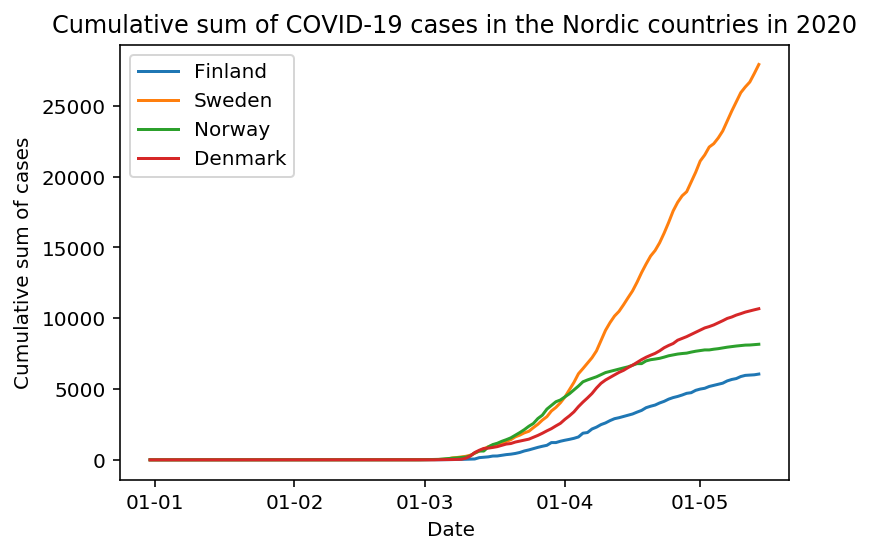

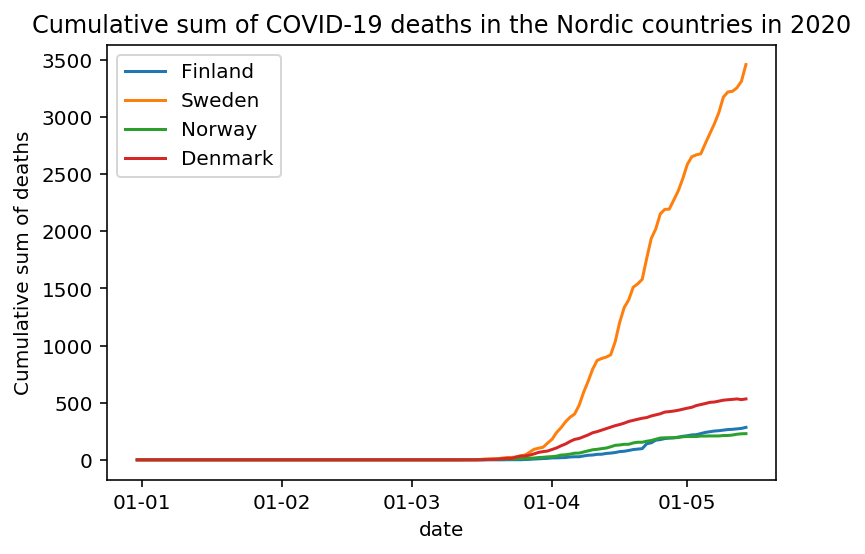

In [18]:
fig,ax = plt.subplots()
for country in ['Finland', 'Sweden', 'Norway', 'Denmark']:
    ax.plot(covid_pd[covid_pd.Country == country].dateRep,covid_pd[covid_pd.Country == country].casesCumsum, label=country)
    
ax.set_xlabel("Date ")
ax.set_ylabel("Cumulative sum of cases")
ax.legend(loc='best')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
ax.set_title('Cumulative sum of COVID-19 cases in the Nordic countries in 2020')

fig,ax = plt.subplots()
for country in ['Finland', 'Sweden', 'Norway', 'Denmark']:
    ax.plot(covid_pd[covid_pd.Country == country].dateRep,covid_pd[covid_pd.Country == country].deathsCumsum, label=country)
    
ax.set_xlabel("date")
ax.set_ylabel("Cumulative sum of deaths")
ax.legend(loc='best')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
ax.set_title('Cumulative sum of COVID-19 deaths in the Nordic countries in 2020')

Text(0.5, 0, 'Date ')

Text(0, 0.5, 'Cumulative sum of cases\nper 100 000 people')

Text(0.5, 1.0, 'Cumulative sum of COVID-19 cases in the Nordic countries in 2020')

Text(0.5, 0, 'date')

Text(0, 0.5, 'Cumulative sum of deaths\nper 100 000 people')

Text(0.5, 1.0, 'Cumulative sum of COVID-19 deaths in the Nordic countries in 2020')

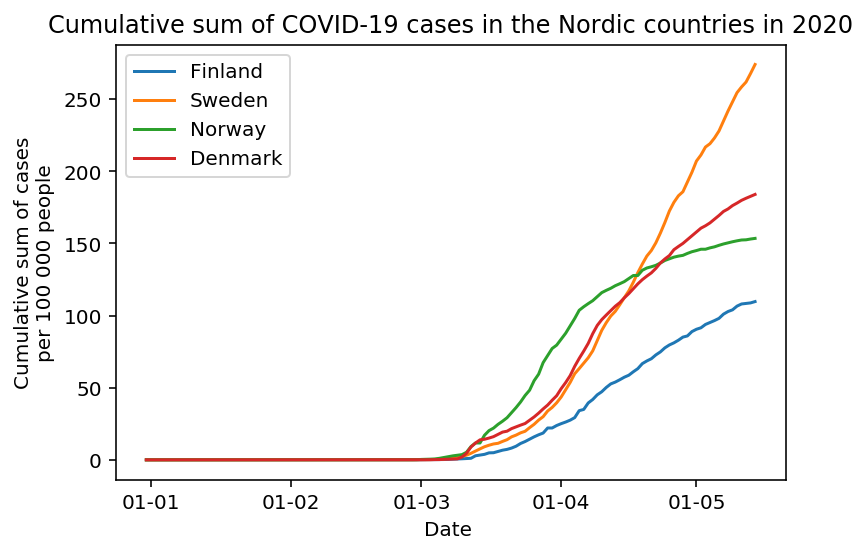

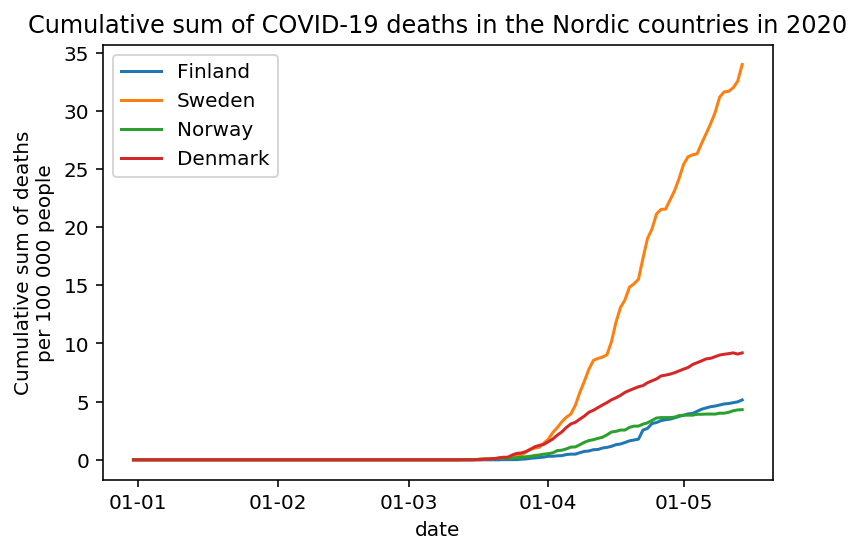

In [19]:
fig,ax = plt.subplots()
for country in ['Finland', 'Sweden', 'Norway', 'Denmark']:
    ax.plot(covid_pd[covid_pd.Country == country].dateRep,covid_pd[covid_pd.Country == country].casesCumsum2, label=country)
    
ax.set_xlabel("Date ")
ax.set_ylabel("Cumulative sum of cases\nper 100 000 people")
ax.legend(loc='best')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
ax.set_title('Cumulative sum of COVID-19 cases in the Nordic countries in 2020')

fig,ax = plt.subplots()
for country in ['Finland', 'Sweden', 'Norway', 'Denmark']:
    ax.plot(covid_pd[covid_pd.Country == country].dateRep,covid_pd[covid_pd.Country == country].deathsCumsum2, label=country)
    
ax.set_xlabel("date")
ax.set_ylabel("Cumulative sum of deaths\nper 100 000 people")
ax.legend(loc='best')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
ax.set_title('Cumulative sum of COVID-19 deaths in the Nordic countries in 2020')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Death rate')

Text(0.5, 1.0, 'Death rate curve of COVID-19 in the Nordic countries in 2020')

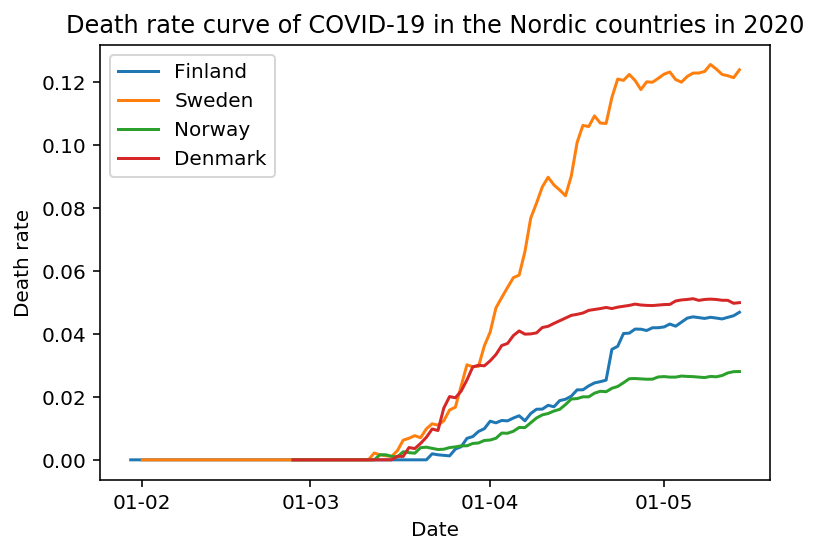

In [20]:
fig,ax = plt.subplots()
for country in ['Finland', 'Sweden', 'Norway', 'Denmark']:
    ax.plot(covid_pd[covid_pd.Country == country].dateRep,covid_pd[covid_pd.Country == country].deathRate, label=country)
    
ax.set_xlabel("Date")
ax.set_ylabel("Death rate")
ax.legend(loc='best')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
ax.set_title('Death rate curve of COVID-19 in the Nordic countries in 2020')

In [21]:
#Find the latest available densities from the population data for each country
#We need a data frame with country column and the latest available population density column



CurrentCovid=covid.filter((F.col('dateRep') == "2020-05-05"))

CurrentCovid.select(F.col("Country")).count()
population_density.select(F.col("Country")).count()
median_age.select(F.col("Country")).count()
hospital_beds.select(F.col("CountryId")).count()
gdp.select(F.col("Country")).count()

Data = CurrentCovid.join(population_density, on=['Country'], how='inner') 
Data = Data.join(median_age, on=['Country'], how='inner')
Data = Data.join(gdp, on=['Country'], how='inner')
Data = Data.join(hospital_beds, on=['CountryId'], how='inner').selectExpr("Country", "CountryId","dateRep","casesCumsum  as TotalCases" ,"deathsCumsum as TotalDeaths",  "casesCumsum2 as TotalCasesPer100000",    "deathsCumsum2 as TotalDeathsPer100000","deathRate", "popData2018",   "populationDensity", "Year as HospitalBedsYear","latestAvailable as HospitalBeds","medianAge", "GDP")

Data.printSchema()

Data.select(F.col("Country")).count()




208

264

184

35

264

root
 |-- Country: string (nullable = true)
 |-- CountryId: string (nullable = true)
 |-- dateRep: date (nullable = true)
 |-- TotalCases: long (nullable = true)
 |-- TotalDeaths: long (nullable = true)
 |-- TotalCasesPer100000: double (nullable = true)
 |-- TotalDeathsPer100000: double (nullable = true)
 |-- deathRate: double (nullable = true)
 |-- popData2018: integer (nullable = true)
 |-- populationDensity: double (nullable = true)
 |-- HospitalBedsYear: string (nullable = true)
 |-- HospitalBeds: double (nullable = true)
 |-- medianAge: double (nullable = true)
 |-- GDP: double (nullable = true)



29

In [22]:
Data.show(vertical=True)

-RECORD 0------------------------------------
 Country              | Latvia               
 CountryId            | LVA                  
 dateRep              | 2020-05-05           
 TotalCases           | 896                  
 TotalDeaths          | 16                   
 TotalCasesPer100000  | 46.50819966551468    
 TotalDeathsPer100000 | 0.8305035654556194   
 deathRate            | 0.017857142857142856 
 popData2018          | 1926542              
 populationDensity    | 30.98330653          
 HospitalBedsYear     | 2017                 
 HospitalBeds         | 3.3                  
 medianAge            | 41.5                 
 GDP                  | 3.4409229178E10      
-RECORD 1------------------------------------
 Country              | Poland               
 CountryId            | POL                  
 dateRep              | 2020-05-05           
 TotalCases           | 14006                
 TotalDeaths          | 698                  
 TotalCasesPer100000  | 36.8787137

In [39]:

#from pyspark.ml.stat import Correlation
#from pyspark.ml.feature import VectorAssembler

from pyspark.mllib.stat import Statistics

features = Data.select("TotalCases" , "TotalDeaths","TotalCasesPer100000","TotalDeathsPer100000","deathRate", "popData2018", "populationDensity","HospitalBeds","medianAge", "GDP")

def compute_correlation_matrix(df, method='pearson'):
    # wrapper around
    # https://forums.databricks.com/questions/3092/how-to-calculate-correlation-matrix-with-all-colum.html
    df_rdd = df.rdd.map(lambda row: row[0:])
    corr_mat = Statistics.corr(df_rdd, method=method)
    corr_mat_df = pd.DataFrame(corr_mat,
                    columns=df.columns, 
                    index=df.columns)
    return round(corr_mat_df,2)

compute_correlation_matrix(features)


,TotalCases,TotalDeaths,TotalCasesPer100000,TotalDeathsPer100000,deathRate,popData2018,populationDensity,HospitalBeds,medianAge,GDP
TotalCases,1.00,0.88,0.31,0.60,0.47,0.49,0.14,-0.09,0.13,0.53
TotalDeaths,0.88,1.00,0.33,0.74,0.70,0.35,0.13,-0.15,0.22,0.43
TotalCasesPer100000,0.31,0.33,1.00,0.61,0.15,-0.24,0.21,-0.21,0.01,-0.10
TotalDeathsPer100000,0.60,0.74,0.61,1.00,0.77,0.03,0.35,-0.11,0.25,0.16
deathRate,0.47,0.70,0.15,0.77,1.00,0.21,0.24,-0.10,0.24,0.24
popData2018,0.49,0.35,-0.24,0.03,0.21,1.00,0.18,0.19,-0.15,0.80
populationDensity,0.14,0.13,0.21,0.35,0.24,0.18,1.00,0.32,0.15,0.34
HospitalBeds,-0.09,-0.15,-0.21,-0.11,-0.10,0.19,0.32,1.00,0.55,0.44
medianAge,0.13,0.22,0.01,0.25,0.24,-0.15,0.15,0.55,1.00,0.33
GDP,0.53,0.43,-0.10,0.16,0.24,0.80,0.34,0.44,0.33,1.00


In [40]:
Data.printSchema()

root
 |-- Country: string (nullable = true)
 |-- CountryId: string (nullable = true)
 |-- dateRep: date (nullable = true)
 |-- TotalCases: long (nullable = true)
 |-- TotalDeaths: long (nullable = true)
 |-- TotalCasesPer100000: double (nullable = true)
 |-- TotalDeathsPer100000: double (nullable = true)
 |-- deathRate: double (nullable = true)
 |-- popData2018: integer (nullable = true)
 |-- populationDensity: double (nullable = true)
 |-- HospitalBedsYear: string (nullable = true)
 |-- HospitalBeds: double (nullable = true)
 |-- medianAge: double (nullable = true)
 |-- GDP: double (nullable = true)



In [41]:
# Drop columns which are not required to compute correlation. Hence, DataFrame with these 4 columns are required to compute correlation. deaths, cases, population density and Hospital.
ndf = Data.drop('CountryId', 'dateRep', 'TotalCases', 'HospitalBedsYear', 'GDP', 'popData2018', 'TotalDeathsPer100000', 'TotalCasesPer100000', 'popData2018', 'TotalDeaths')

In [42]:
ndf.printSchema()

root
 |-- Country: string (nullable = true)
 |-- deathRate: double (nullable = true)
 |-- populationDensity: double (nullable = true)
 |-- HospitalBeds: double (nullable = true)
 |-- medianAge: double (nullable = true)



In [43]:
# Computing correlation between populationDensity and Hospital beds pair wise frequency with crosstab correlation. 
#   
#HP_corr = ndf.stat.crosstab('HospitalBeds', 'populationDensity')
HP_corr = ndf.corr('populationDensity', 'HospitalBeds')
HP_corr
# Populationdensity and Hospital beds are correlated as we can see in the reults correlation between popolation denisty and hospital beds is 0.3225 which means the correlation is about 32% of population and avaliable hospital beds in the countires inlcuding Nordic Countries. 
HP1_corr = ndf.corr('deathRate', 'populationDensity')
HP1_corr
HP2_corr = ndf.corr('deathRate', 'HospitalBeds') 
HP2_corr


0.32245611118386835

0.24349903732399078

-0.1038069497638674

In [44]:
from pyspark.mllib.stat import Statistics
import pandas as pd
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation


In [45]:
def compute_correlation_matrix(ndf, method='pearson'):
    df_rdd = ndf.rdd.map(lambda row: row[0:])
    corr_mat = Statistics.corr(df_rdd, method=method)
    corr_mat_df = pd.DataFrame(corr_mat, columns=ndf.columns, index=ndf.columns)
    
    return corr_mat_df
    


In [46]:
# To see DataFrame 
Data.describe().show()

+-------+-------+---------+------------------+-----------------+-------------------+--------------------+--------------------+--------------------+------------------+-------------------+------------------+------------------+--------------------+
|summary|Country|CountryId|        TotalCases|      TotalDeaths|TotalCasesPer100000|TotalDeathsPer100000|           deathRate|         popData2018| populationDensity|   HospitalBedsYear|      HospitalBeds|         medianAge|                 GDP|
+-------+-------+---------+------------------+-----------------+-------------------+--------------------+--------------------+--------------------+------------------+-------------------+------------------+------------------+--------------------+
|  count|     29|       29|                29|               29|                 29|                  29|                  29|                  29|                29|                 29|                29|                29|                  29|
|   mean|   null

In [47]:
# To change schema according to algorithm requirements. 
from pyspark.sql.types import StructField, StringType, IntegerType, StructType

In [48]:
Data.groupBy('HospitalBeds').avg().show()

+------------+---------------+----------------+------------------------+-------------------------+--------------------+----------------+----------------------+-----------------+--------------+---------------+
|HospitalBeds|avg(TotalCases)|avg(TotalDeaths)|avg(TotalCasesPer100000)|avg(TotalDeathsPer100000)|      avg(deathRate)|avg(popData2018)|avg(populationDensity)|avg(HospitalBeds)|avg(medianAge)|       avg(GDP)|
+------------+---------------+----------------+------------------------+-------------------------+--------------------+----------------+----------------------+-----------------+--------------+---------------+
|        2.62|       211938.0|         29079.0|        350.709085557558|       48.119117378328674| 0.13720522039464372|     6.0431283E7|           205.4507479|             2.62|          44.3|     2.08386E12|
|        3.56|        29898.0|          1476.0|       351.0579351269641|       17.330975725714055|0.049367850692354005|       8516543.0|           215.5213784|     

In [49]:
Data_s = [StructField('Country', DoubleType(), True)]

In [50]:
df1 = Data.select(['Country','TotalCases', 'TotalDeaths']).show()


+-----------+----------+-----------+
|    Country|TotalCases|TotalDeaths|
+-----------+----------+-----------+
|     Latvia|       896|         16|
|     Poland|     14006|        698|
|     France|    131863|      25201|
|      Italy|    211938|      29079|
|     Mexico|     24905|       2271|
|    Hungary|      3065|        363|
|     Norway|      7847|        208|
|    Finland|      5327|        240|
|Netherlands|     40770|       5082|
| Luxembourg|      3828|         96|
|     Turkey|    127659|       3461|
|    Austria|     15569|        600|
|     Israel|     16246|        235|
|   Portugal|     25524|       1063|
|  Lithuania|      1419|         46|
|      Chile|     20643|        270|
|     Canada|     60772|       3854|
|    Denmark|      9670|        493|
|      Spain|    220244|      25613|
|    Estonia|      1703|         55|
+-----------+----------+-----------+
only showing top 20 rows



In [51]:
df1 = Data.select(['Country','populationDensity', 'HospitalBeds', 'deathRate']).show()

+-----------+-----------------+------------+--------------------+
|    Country|populationDensity|HospitalBeds|           deathRate|
+-----------+-----------------+------------+--------------------+
|     Latvia|      30.98330653|         3.3|0.017857142857142856|
|     Poland|      124.0358862|        4.85| 0.04983578466371555|
|     France|      122.3383957|        3.09| 0.19111502089289642|
|      Italy|      205.4507479|        2.62| 0.13720522039464372|
|     Mexico|      64.91462641|        1.38| 0.09118650873318611|
|    Hungary|      107.9066055|        4.27| 0.11843393148450244|
|     Norway|      14.55491954|         3.2| 0.02650694532942526|
|    Finland|      18.15685565|         2.8|0.045053501032476066|
|Netherlands|      511.4579104|        2.92|  0.1246504782928624|
| Luxembourg|      250.0938272|         3.7|0.025078369905956112|
|     Turkey|      106.9601289|        2.78| 0.02711128866746567|
|    Austria|      107.2069267|        5.45| 0.03853812062431755|
|     Isra

In [52]:
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.stat import Statistics
from pyspark.ml.linalg import  Vector
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

In [53]:
assembler = VectorAssembler(inputCols=[
"TotalCases" , "HospitalBeds","deathRate", "popData2018", "populationDensity"], outputCol= 'features')

In [55]:
output = assembler.transform(features).show()

+----------+-----------+-------------------+--------------------+--------------------+-----------+-----------------+------------+---------+---------------+--------------------+
|TotalCases|TotalDeaths|TotalCasesPer100000|TotalDeathsPer100000|           deathRate|popData2018|populationDensity|HospitalBeds|medianAge|            GDP|            features|
+----------+-----------+-------------------+--------------------+--------------------+-----------+-----------------+------------+---------+---------------+--------------------+
|       896|         16|  46.50819966551468|  0.8305035654556194|0.017857142857142856|    1926542|      30.98330653|         3.3|     41.5|3.4409229178E10|[896.0,3.3,0.0178...|
|     14006|        698|  36.87871374124149|  1.8378796366833194| 0.04983578466371555|   37978548|      124.0358862|        4.85|     38.8|     5.85664E11|[14006.0,4.85,0.0...|
|    131863|      25201|  196.8479252557397|     37.620595347974| 0.19111502089289642|   66987244|      122.3383957

In [56]:
assembler = VectorAssembler(inputCols=[ 'populationDensity', 'HospitalBeds'], outputCol='features')


In [57]:
output = assembler.transform(ndf)

In [58]:
output.select('features').show()

+------------------+
|          features|
+------------------+
| [30.98330653,3.3]|
|[124.0358862,4.85]|
|[122.3383957,3.09]|
|[205.4507479,2.62]|
|[64.91462641,1.38]|
|[107.9066055,4.27]|
| [14.55491954,3.2]|
| [18.15685565,2.8]|
|[511.4579104,2.92]|
| [250.0938272,3.7]|
|[106.9601289,2.78]|
|[107.2069267,5.45]|
|[410.5268022,2.19]|
|[112.2394535,3.25]|
|[44.53135138,5.47]|
|[25.18944607,1.99]|
|[4.075308214,1.95]|
|[138.0673017,2.42]|
|[93.52905826,2.43]|
|[30.38610536,3.45]|
+------------------+
only showing top 20 rows



In [59]:
output.head()

Row(Country='Latvia', deathRate=0.017857142857142856, populationDensity=30.98330653, HospitalBeds=3.3, medianAge=41.5, features=DenseVector([30.9833, 3.3]))

In [60]:
final_comp = output.select('features', 'deathRate')

In [61]:
final_comp.show()

+------------------+--------------------+
|          features|           deathRate|
+------------------+--------------------+
| [30.98330653,3.3]|0.017857142857142856|
|[124.0358862,4.85]| 0.04983578466371555|
|[122.3383957,3.09]| 0.19111502089289642|
|[205.4507479,2.62]| 0.13720522039464372|
|[64.91462641,1.38]| 0.09118650873318611|
|[107.9066055,4.27]| 0.11843393148450244|
| [14.55491954,3.2]| 0.02650694532942526|
| [18.15685565,2.8]|0.045053501032476066|
|[511.4579104,2.92]|  0.1246504782928624|
| [250.0938272,3.7]|0.025078369905956112|
|[106.9601289,2.78]| 0.02711128866746567|
|[107.2069267,5.45]| 0.03853812062431755|
|[410.5268022,2.19]|0.014465099101317247|
|[112.2394535,3.25]|0.041647077260617456|
|[44.53135138,5.47]| 0.03241719520789288|
|[25.18944607,1.99]|0.013079494259555298|
|[4.075308214,1.95]| 0.06341736325939577|
|[138.0673017,2.42]| 0.05098241985522234|
|[93.52905826,2.43]| 0.11629374693521731|
|[30.38610536,3.45]| 0.03229594832648268|
+------------------+--------------

In [62]:
train_data, test_data = final_comp.randomSplit([0.7, 0.3])

In [63]:
train_data.describe().show()

+-------+--------------------+
|summary|           deathRate|
+-------+--------------------+
|  count|                  20|
|   mean| 0.06558279993543481|
| stddev|0.052549604576155914|
|    min|0.005558643690939411|
|    max| 0.19111502089289642|
+-------+--------------------+



In [64]:
test_data.describe().show()

+-------+--------------------+
|summary|           deathRate|
+-------+--------------------+
|  count|                   9|
|   mean| 0.05993827501351891|
| stddev| 0.03796443014630444|
|    min|0.017857142857142856|
|    max|  0.1246504782928624|
+-------+--------------------+



In [70]:
lr = LinearRegression(labelCol='deathRate')

In [71]:
linear_model = lr.fit(train_data)